<p style="text-align: center">
<img src="../../assets/images/dtlogo.png" alt="Duckietown" width="50%">
</p>

# 💻 06 - PID controller homework

In the previous activities we have built up the tools needed to deploy a PID controller. We have used as control signal the angular speed ($\omega$) and as controlled variable the heading of the Duckiebot ($\theta$).

In this exercise you will use what you have learned so far to write a PID controller to command the angular speed of your Duckiebot, to compensate an initial lateral position offset of $0.2 \text{m}$. 

Your robot will have to rely on its own odometry to estimate its current position.

**Note**: the function(s) used to compute the odometry will be taken from your previous answers in the [odometry activity](../04-Odometry/odometry_activity.ipynb). Make sure you are happy about them!

The Duckiebot's speed is constant and given: $v_0 = 0.2$. 

May the duck be with you!

## Implement PID controller for lateral control

Implement the function `PIDController` inside the file `packages/solution/pid_controller_homework.py`.

The controller you are asked to write performs PID control on the $y$ coordinate (in the world frame) of the Duckiebot. It receives the following inputs:

    v_0:        linear Duckiebot speed (constant).
    y_ref:      target y coordinate.
    y_hat:      the current estimated y.
    prev_e_y:   tracking error at previous iteration.
    prev_int_y: previous integral error term.
    delta_t:    time interval since last call.

and it will produce the following outputs:

    v_0:     linear velocity of the Duckiebot
    omega:   angular velocity of the Duckiebot
    e:       current tracking error (automatically becomes prev_e_y at next iteration).
    e_int:   current integral error (automatically becomes prev_int_y at next iteration).


### Sanity Check

In [1]:
%load_ext autoreload
%autoreload 2

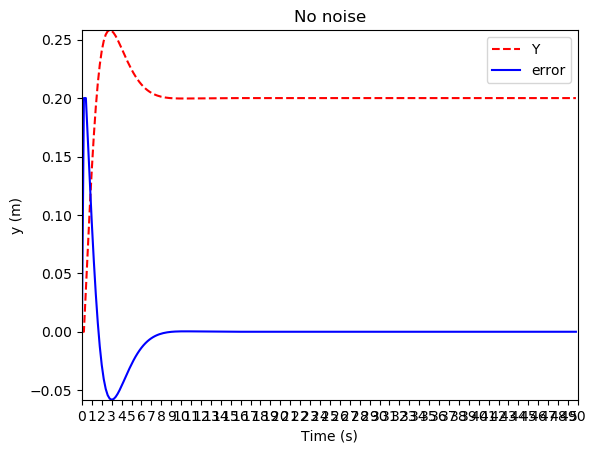

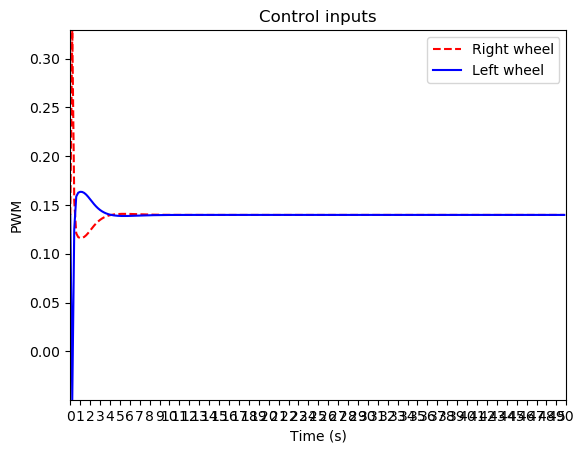

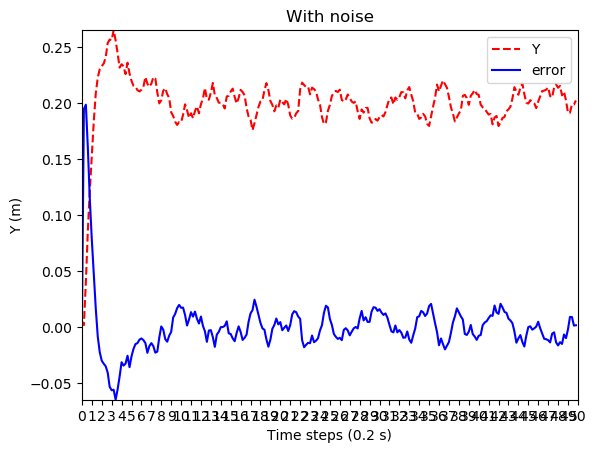

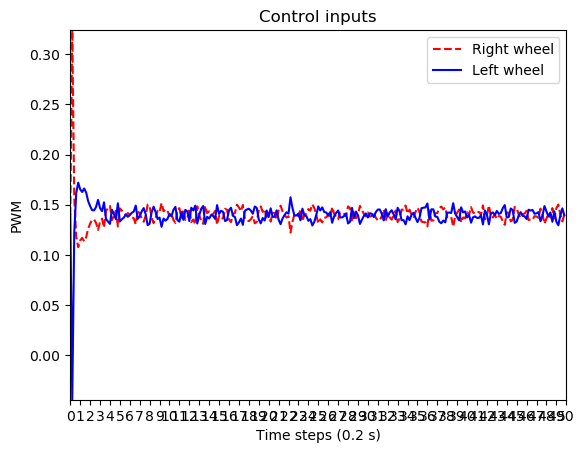

In [2]:
from tests.unit_test import UnitTestPositionPID

from solution.pid_controller_homework import PIDController

# Write here the values of the kinematics parameters you calculated during the activities.
# This test will give you an idea of the behavior of the controller you wrote above.
# Try to play with the parameters, change R, the baseline all the PID variables,
# What change in the resulting graphs? Why?

# Note: this sanity check is neither a prerequisite for completing the exercise nor an instrument for tuning your controller. 

R = 0.0318
baseline = 0.1
gain = 0.6
trim = 0.0
v_0 = 0.2
y_ref = 0.2

# unit test input R, baseline, v_0, gain, trim, PIDController
unit_test = UnitTestPositionPID(R, baseline, v_0, y_ref, gain, trim, PIDController) 
unit_test.test()


# PID tuning

In order to tune the PID two approaches of increasing fedelity are possible:
1. Kinematic model $\dot{q}=Aq$: only simulating the kinematics of the Duckiebot
2. Dynamics model $F=ma$: simulate the dynamics of the Duckiebot, with forces and inertia.

### Tuning scenario
You will tune the PID in a scenario similar to the one in the first AIDO challenge of this learning experience:

- **Starting pose:** $x_0,y_0,\theta_0=[0 m, 0.2 m, 0°]$
- **Commanded velocity:** $v_0=0.22m/s$
- **Goal**: getting to $y_{ref}=0.0m$

This is equivalent to starting in the wrong lane and try following the centerline of the correct lane.

In [3]:
# Initial conditions of the duckiebot
x0 = 0.0
y0 = 0.2
theta_0 = 0.0 # degrees

initial_pose =  [x0,y0,theta_0]
initial_vel =   [0.0, 0]

# Goal:
y_ref = 0

# Kinematic model
In this part of the notebook you will tune the PID on a kinematic model of the Duckiebot. This is the simplest model of the robot and it will be your first step to get an idea of the values.

In [4]:
import matplotlib.pyplot as plt

from utils.writer import load_gains, update_gains

def plot_xy_from_lists(xs,ys,y_ref):
    # Plot (x,y) position
    ax = plt.subplot(313)
    plt.grid('on')
    plt.plot(xs, ys)

    plt.axhline(y = y_ref, color = 'r', linestyle = '--')

    plt.xlabel('x', fontsize=12)
    plt.ylabel('y', fontsize=12)

    # Set grass background
    ax.set_facecolor('g')

    top_line=0.2
    bottom_line=-0.2

    # Draw road
    ax.axhspan(ymin=bottom_line,ymax=top_line,facecolor='k')
    plt.axhline(y=top_line,linestyle='-',color='w') # white
    plt.axhline(y=bottom_line,linestyle='-',color='w')
    plt.axhline(y=0.0,linestyle='--',color='#fefe03')

    ax.set_ylim(bottom=-0.3,top=0.3)

    plt.show()


In [5]:
from simulators import integrate_kinematics
from solution.pid_controller_homework import PIDController

def compute_response(initial_pose, initial_vel = [0,0], y_ref=0,dynamics=integrate_kinematics):
    
    xs, ys, omegas, e_list, angles = dynamics(
        initial_pose,initial_vel,y_ref,controller=PIDController,
        )
        
    plot_xy_from_lists(xs,ys,y_ref)

def tune_gains(kp,kd,ki):
        # write values from sliders to file PID_HOMEWORK_GAINS.py
        update_gains(kp,kd,ki)

        # simulate the controller
        compute_response(initial_pose,y_ref=y_ref,dynamics=integrate_kinematics)

from ipywidgets import interact

interact(tune_gains, kp=5.0,kd=5.0,ki=1.0)

/code/catkin_ws/src/modcon/packages/simulators/dynamics_sim.py:114: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (delta_phi is not None, "Need to pass a delta_phi function!")
DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:duckietown_world:duckietown-world version 6.4.3 path /usr/local/lib/python3.8/dist-packages
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /usr/local/lib/python3.8/dist-packages
DEBUG:aido_schemas:aido-protocols version 6.1.1 path /usr/local/lib/python3.8/dist-packages
DEBUG:nodes:version 6.2.17 path /usr/local/lib/python3.8/dist-packages pyparsing 2.4.6


interactive(children=(FloatSlider(value=5.0, description='kp', max=15.0, min=-5.0), FloatSlider(value=5.0, des…

<function __main__.tune_gains(kp, kd, ki)>

# PID Tuning - Dynamic model
For convenience you can simulate here the dynamic behavior of the robot on the x-y plane without having to run the full simulator. This allows you to tweak the gains of the PID and quickly see the effect on the response of the system.

Let's plot the position of the duckiebot on the $xy$ plane:

In [6]:
from simulators import integrate_dynamics
from solution.pid_controller_homework import PIDController

def tune_gains(kp,kd,ki):
        # write values from sliders to file PID_HOMEWORK_GAINS.py
        update_gains(kp,kd,ki)

        # simulate the controller
        compute_response(initial_pose,y_ref=y_ref,dynamics=integrate_dynamics)

interact(tune_gains, kp=5.0,kd=5.0,ki=1.0)

interactive(children=(FloatSlider(value=5.0, description='kp', max=15.0, min=-5.0), FloatSlider(value=5.0, des…

<function __main__.tune_gains(kp, kd, ki)>

# PID Tuning: dynamic model with odometry

Now to get the current pose we use the odometry function you developed. In particular $\hat{y}$ (the estimate of the current $y$ position) is fed to the PID controller and the `dynamics` function now also gets as argument the two functions you developed in the odometry activity (`delta_phi` and `pose_estimation`).

In [7]:
from solution.odometry_activity import  delta_phi, pose_estimation

# We redefine `compute_response` to use the odometry functions as well

def compute_response(initial_pose, initial_vel = [0,0], y_ref=0,dynamics=integrate_kinematics):
    
    xs, ys, omegas, e_list, angles = dynamics(
        initial_pose,initial_vel,y_ref,controller=PIDController,odometry_function=pose_estimation,delta_phi=delta_phi
        )
        
    plot_xy_from_lists(xs,ys,y_ref)

def tune_gains(kp,kd,ki):
        # write values from sliders to file PID_HOMEWORK_GAINS.py
        update_gains(kp,kd,ki)

        # simulate the controller
        compute_response(initial_pose,y_ref=y_ref,dynamics=integrate_dynamics)

interact(tune_gains, kp=5.0,kd=5.0,ki=1.0)

interactive(children=(FloatSlider(value=5.0, description='kp', max=15.0, min=-5.0), FloatSlider(value=5.0, des…

<function __main__.tune_gains(kp, kd, ki)>

You see that there's a difference in the behavior of the robot compared to the dynamics simulator _without odometry_.

*   Can you explain what is it?
*   What do you think might be the cause of this difference?
*   How could you check if your hypothesis is correct?

## Testing instructions and outcome examples

Here are some examples of stable outcomes (not necessarily the best you can get):

### 💻 Simulation 

1. Write the controller above, save this page (`Ctrl-S`), and run both:

        dts code build
        dts code workbench --sim


2. Click on the "PID Exercise" icon on the VNC desktop

3. Bring up the interaction panel (it might be hidden behind RVIZ, highlight it through the shortcut on the bottom bar of VNC) and type the desired reference position $y_{ref}$ (in **meters**) and Duckiebot linear speed ($v_0$). 

4. Press on `Send Commands` to start, `Stop` to stop. 

5. `Ctrl-C` on the computer terminal used to launch the simulator to close the instance. 

<figure>
  <div style="text-align:center;">
  <img src="../../assets/images/pid-control/pid-lateral-sim-good.png" alt="pid-lateral-sim-1" style="width: 300px;"/>
  <p>Simulation, lateral PID control. 

$$v_{0} = 0.2, y_{ref} = [0.2, -0.1]$$
</p>
  </div>
</figure>

### 🚙 Duckiebot

0. Make sure your Duckiebot is powered on and connected to the network. Note: For the controller to run properly on your robot, you need to have completed the [camera calibration](https://docs.duckietown.com/daffy/opmanual-duckiebot/operations/calibration_camera/index.html) and [wheel calibration](https://docs.duckietown.com/daffy/opmanual-duckiebot/operations/calibration_wheels/index.html) steps found in the Duckiebot operation manual.

1. Write the controller above, save this page (`Ctrl-S`), run:


        dts code build
        dts code workbench -b ROBOTNAME


2. Click on the "PID Exercise" icon on the VNC desktop

3. Bring up the interaction panel (it might be hidden behind RVIZ, highlight it through the shortcut on the bottom bar of VNC) and type the desired reference position $y_{ref}$ (in **meters**) and Duckiebot linear speed ($v_0$). 

4. Press on `Send Commands` to start, `Stop` to stop. 

5. `Ctrl-C` on the computer terminal used to launch the simulator to close the instance. 

<figure>
  <div style="text-align:center;">
  <img src="../../assets/images/pid-control/pid-lateral-real-good.png" alt="pid-lateral-real-1" style="width: 300px;"/>
  <p>Duckiebot, lateral PID control. 
  
  $$v_{0} = 0.2, y_{ref} = [0.2, -0.2, 0.2]$$
  </p>
  </div>
</figure>

# Local evaluation and remote submission of your homework exercise


⚠️ You must submit this homework for evaluation, by following the `Remote evalutation` instructions below.⚠️ 

## Local evaluation

If you want (this is not necessary) you can evaluate your submission locally before shipping it to the cloud. This will provide you access to detailed performacne metrics of your controller on various episodes. Note that this will take a while to run (~30-60 minutes). 

1. Open a terminal, navigate to the exercise folder and run:


        dts code evaluate
        

2. The result of the simulation can be visualized in realtime at the link printed by the evaluator, for example:

<figure>
  <div style="text-align:center;">
  <img src="../../assets/images/pid-exercise/screen-aido-eval.png" alt="pid-lateral-real-1" style="width: 900px;"/>
  <p>Visualize the simulation at the link printed during the evaluation.</p>
  </div>
</figure>

3. The evaluation output is saved locally at the end of the evaluation process. 

## Remote submission (⚠️ This part is required to submit your homework ⚠️)

You can submit your agent for evaluation by: 

1. Opening a terminal on your computer, navigating to the exercise folder and running:


        dts code submit
        

2. The result of the submission can be visualized on the AI-DO challenges website.

After some processing, you should see something like this:

```

~        ## Challenge lx22-modcon - MOOC - ModCon
~        
~                Track this submission at:
~        
~                    https://challenges.duckietown.org/v4/humans/submissions/SUBMISSION-NUMBER
~        
~                You can follow its fate using:
~        
~                    $ dts challenges follow --submission SUBMISSION-NUMBER
~        
~                You can speed up the evaluation using your own evaluator:
~        
~                    $ dts challenges evaluator --submission SUBMISSION-NUMBER
~        
~                For more information, see the manual at https://docs-old.duckietown.org/daffy/AIDO/out/
~        

```

Congratulations, you have completed the modeling and control activities! 